In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

np.random.seed(114514)
xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Waveform generation 

In [5]:
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1.), 
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99),
    'coalescence_time': np.random.uniform(t_start + DAY, t_end) / DAY, # [day], start from t_start to ensure that at least 1-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5.)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(0, TWOPI), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1.)), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
mbhb_parameters

{'chirp_mass': 1540834.0744329947,
 'mass_ratio': 0.7085556468373223,
 'spin_1z': -0.145309333881942,
 'spin_2z': 0.5604040823225795,
 'coalescence_time': 14.153499632527323,
 'coalescence_phase': 0.22723542654969606,
 'luminosity_distance': 78958.20214893803,
 'inclination': 1.0242620672883695,
 'longitude': 1.3208186729980294,
 'latitude': 0.3431974332207405,
 'psi': 0.4614176140098712}

In [6]:
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)
wf_channels.shape 

(3, 21077)

## Noise generation 

In [7]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
# print("arm lengths:", arms)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# generate frequency-domain noises as Gaussian and stationary 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, noise_channels.shape, InvCovMat.shape 

((3, 21077), (3, 21077), (21077, 3, 3))

## Data combination 

In [8]:
data_channels = wf_channels + noise_channels 

Text(0, 0.5, 'Frequency-domain data (1/Hz)')

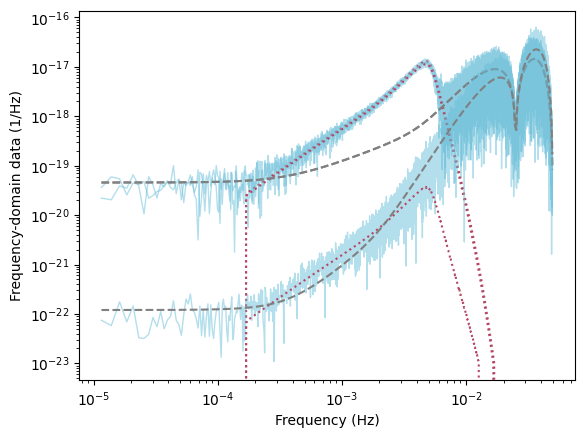

In [9]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Fisher analysis 
calculate the theoretical bounds 

In [10]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.001,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 14.519942545928144
shift = 5.0 relative diff = 6.351063936448074e-07
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.01884651558831706
shift = 0.005 relative diff = 0.001624701621362141
error = 0.01881708953041234
shift = 0.0025 relative diff = 0.002007013680462065
error = 0.018802636497321036
shift = 0.00125 rel

In [11]:
FIM.param_errors

{'chirp_mass': 903.9484102131003,
 'mass_ratio': 0.013547277624766258,
 'spin_1z': 0.08724364303769669,
 'spin_2z': 0.11848513980321725,
 'coalescence_time': 9.407541788818293e-05,
 'coalescence_phase': 0.03931686536244497,
 'luminosity_distance': 6208.94615464064,
 'inclination': 0.027488783897813597,
 'longitude': 0.044221441076738054,
 'latitude': 0.0552414682632487,
 'psi': 0.027442052284146302}

In [12]:
opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
opt_SNR

1095.1561350469588

## Likelihood 

In [13]:
Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


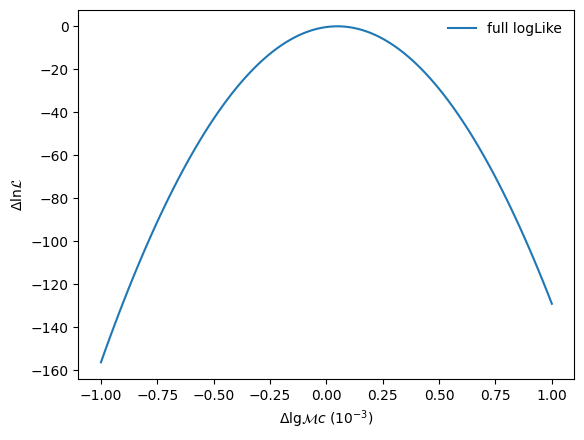

In [14]:
fiducial_param_arr = ParamDict2ParamArr(mbhb_parameters)

N_test=101
test_idx = 0 # lgMc 
test_params = np.linspace(-1e-3, 1e-3, N_test) + fiducial_param_arr[test_idx]

full_lls = [] # store the full loglikelihood 
for i_test in range(N_test):
    tmp_params = np.array(fiducial_param_arr).copy()
    tmp_params[test_idx] = test_params[i_test]
    full_lls.append(Like.full_log_like(tmp_params))
full_lls = np.array(full_lls)

plt.plot((test_params - fiducial_param_arr[test_idx])*1e3, full_lls - np.max(full_lls), label="full logLike")
plt.xlabel(r'$\Delta {\rm lg} \mathcal{M}c \ (10^{-3})$')
plt.ylabel(r'$\Delta {\rm ln} \mathcal{L}$')
plt.legend(frameon=False)

## Bilby wrapper 

In [15]:
import bilby 

In [16]:
priors = bilby.core.prior.PriorDict()
priors["chirp_mass"] = bilby.prior.Uniform(minimum=mbhb_parameters["chirp_mass"]-10.*FIM.param_errors["chirp_mass"], maximum=mbhb_parameters["chirp_mass"]+10.*FIM.param_errors["chirp_mass"], name='chirp_mass', latex_label='$\mathcal{M}_c$')
priors["mass_ratio"] = bilby.prior.Uniform(minimum=max(0.1, mbhb_parameters["mass_ratio"]-10.*FIM.param_errors["mass_ratio"]), maximum=min(1., mbhb_parameters["mass_ratio"]+10.*FIM.param_errors["mass_ratio"]), name="mass_ratio", latex_label='$q$')
priors["spin_1z"] = bilby.prior.Uniform(minimum=max(-0.99, mbhb_parameters["spin_1z"]-10.*FIM.param_errors["spin_1z"]), maximum=min(0.99, mbhb_parameters["spin_1z"]+10.*FIM.param_errors["spin_1z"]), name="spin_1z", latex_label='$\chi_{z1}$')
priors["spin_2z"] = bilby.prior.Uniform(minimum=max(-0.99, mbhb_parameters["spin_2z"]-10.*FIM.param_errors["spin_2z"]), maximum=min(0.99, mbhb_parameters["spin_2z"]+10.*FIM.param_errors["spin_2z"]), name="spin_2z", latex_label='$\chi_{z2}$')
priors["coalescence_time"] = bilby.prior.Uniform(minimum=mbhb_parameters["coalescence_time"]-10.*FIM.param_errors["coalescence_time"], maximum=mbhb_parameters["coalescence_time"]+10.*FIM.param_errors["coalescence_time"], name="coalescence_time", latex_label='$t_c$') 
priors["coalescence_phase"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="coalescence_phase", latex_label='$\\varphi_c$', boundary="periodic")
priors["luminosity_distance"] = bilby.prior.Uniform(minimum=mbhb_parameters["luminosity_distance"]-10.*FIM.param_errors["luminosity_distance"], maximum=mbhb_parameters["luminosity_distance"]+10.*FIM.param_errors["luminosity_distance"], name="luminosity_distance", latex_label='$d_L$')
priors["inclination"] = bilby.prior.Sine(minimum=0., maximum=PI, name="inclination", latex_label='$\iota$')
priors["longitude"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="longitude", latex_label='$\lambda$', boundary="periodic")
priors["latitude"] = bilby.prior.Cosine(minimum=-PI/2., maximum=PI/2., name="latitude", latex_label='$\\beta$')
priors["psi"] = bilby.prior.Uniform(minimum=0., maximum=PI, name="psi", latex_label='$\psi$', boundary="periodic")

In [17]:
priors

{'chirp_mass': Uniform(minimum=1531794.5903308636, maximum=1549873.5585351258, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5730828705896598, maximum=0.8440284230849848, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'spin_1z': Uniform(minimum=-0.99, maximum=0.7271270964950249, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None),
 'spin_2z': Uniform(minimum=-0.6244473157095929, maximum=0.99, name='spin_2z', latex_label='$\\chi_{z2}$', unit=None, boundary=None),
 'coalescence_time': Uniform(minimum=14.152558878348442, maximum=14.154440386706204, name='coalescence_time', latex_label='$t_c$', unit=None, boundary=None),
 'coalescence_phase': Uniform(minimum=0.0, maximum=6.283185307179586, name='coalescence_phase', latex_label='$\\varphi_c$', unit=None, boundary='periodic'),
 'luminosity_distance': Uniform(minimum=16868.74060253163, maximum=141047.6636953444, name='luminosity_distance', la

In [18]:
class bilby_likelihood_wrapper(bilby.Likelihood):
    def __init__(self, triangle_likelihood, likelihood_type="full"):
        """ wrap a triangle likelihood to get a bilby likelihood, type can be "full" or "heterodyned" """
        super().__init__(
            parameters={
                'chirp_mass': None,
                'mass_ratio': None,
                'spin_1z': None,
                'spin_2z': None,
                'coalescence_time': None,
                'coalescence_phase': None,
                'luminosity_distance': None,
                'inclination': None,
                'longitude': None,
                'latitude': None,
                'psi': None
            }
        )
        if likelihood_type == "full":
            self.LLfunc = triangle_likelihood.full_log_like
        elif likelihood_type == "heterodyned":
            self.LLfunc = triangle_likelihood.het_log_like
        else:
            raise ValueError("wrong likelihood type. it should only be full or heterodyned.")

    def log_likelihood(self):
        return self.LLfunc(ParamDict2ParamArr(self.parameters))

In [19]:
BLike_full = bilby_likelihood_wrapper(triangle_likelihood=Like, likelihood_type="full")

In [20]:
sampler_name = "nessai"
# sampler_name = "dynesty"

In [21]:
# import multiprocessing
# print("number of cpus =", multiprocessing.cpu_count())

result = bilby.run_sampler(
    likelihood=BLike_full, 
    priors=priors,
    sampler=sampler_name, 
    nlive=1000,
    walks=20,
    nact=50,
    maxmcmc=2000,
    dlogz=0.3,
    # npool=multiprocessing.cpu_count(),
    npool=None, 
    injection_parameters=mbhb_parameters, 
    outdir="../../Results/bilby_outdir",
    label="test_full_likelihood_5day",
    plot=True,
    resume=False, 
    # resume=True, 
)

17:00 bilby INFO    : Running for label 'test_full_likelihood_5day', output will be saved to '../../Results/bilby_outdir'
/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/bilby/core/utils/log.py:73: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  vdict[key] = str(getattr(sys.modules[key], "__version__", "N/A"))
17:00 bilby INFO    : Analysis priors:
17:00 bilby INFO    : chirp_mass=Uniform(minimum=1531794.5903308636, maximum=1549873.5585351258, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None)
17:00 bilby INFO    : mass_ratio=Uniform(minimum=0.5730828705896598, maximum=0.8440284230849848, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
17:00 bilby INFO    : spin_1z=Uniform(minimum=-0.99, maximum=0.7271270964950249, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None)
17:00 bilby INFO    : s

07-14 17:00 nessai INFO    : Running Nessai version 0.14.0.post0
07-14 17:00 nessai INFO    : pool and n_pool are none, no multiprocessing pool
07-14 17:00 nessai INFO    : Initialising nested sampler


/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/nessai/utils/logging.py:133: FutureWarning: setup_logger is deprecated, use configure_logger instead
  warnings.warn(


07-14 17:00 nessai WARNING : Multiprocessing pool has already been configured.
07-14 17:00 nessai WARNING : Removing unused keyword arguments ({'max_n_clusters', 'n_steps', 'marginalise_augment', 'step_type', 'generate_augment', 'n_marg', 'plot_chain', 'step_kwargs', 'augment_dims', 'ensemble_fraction', 'enforce_likelihood_threshold', 'plot_history', 'n_accept'}) from kwargs for FlowProposal. These are valid keyword arguments but correspond to other proposal classes.
07-14 17:00 nessai INFO    : Passing kwargs to FlowProposal: {'training_config': None, 'poolsize': 1000, 'check_acceptance': False, 'max_poolsize_scale': 10, 'update_poolsize': True, 'accumulate_weights': False, 'save_training_data': False, 'reparameterisations': None, 'fallback_reparameterisation': 'zscore', 'use_default_reparameterisations': None, 'reverse_reparameterisations': False, 'map_to_unit_hypercube': False, 'latent_prior': 'truncated_gaussian', 'constant_volume_mode': True, 'volume_fraction': 0.95, 'fuzz': 1.0, 

08:08 bilby INFO    : Sampling time: 2 days, 15:06:50.137668
08:08 bilby INFO    : Summary of results:
nsamples: 5678
ln_noise_evidence:    nan
ln_evidence: -42147.345 +/-  0.214
ln_bayes_factor:    nan +/-  0.214



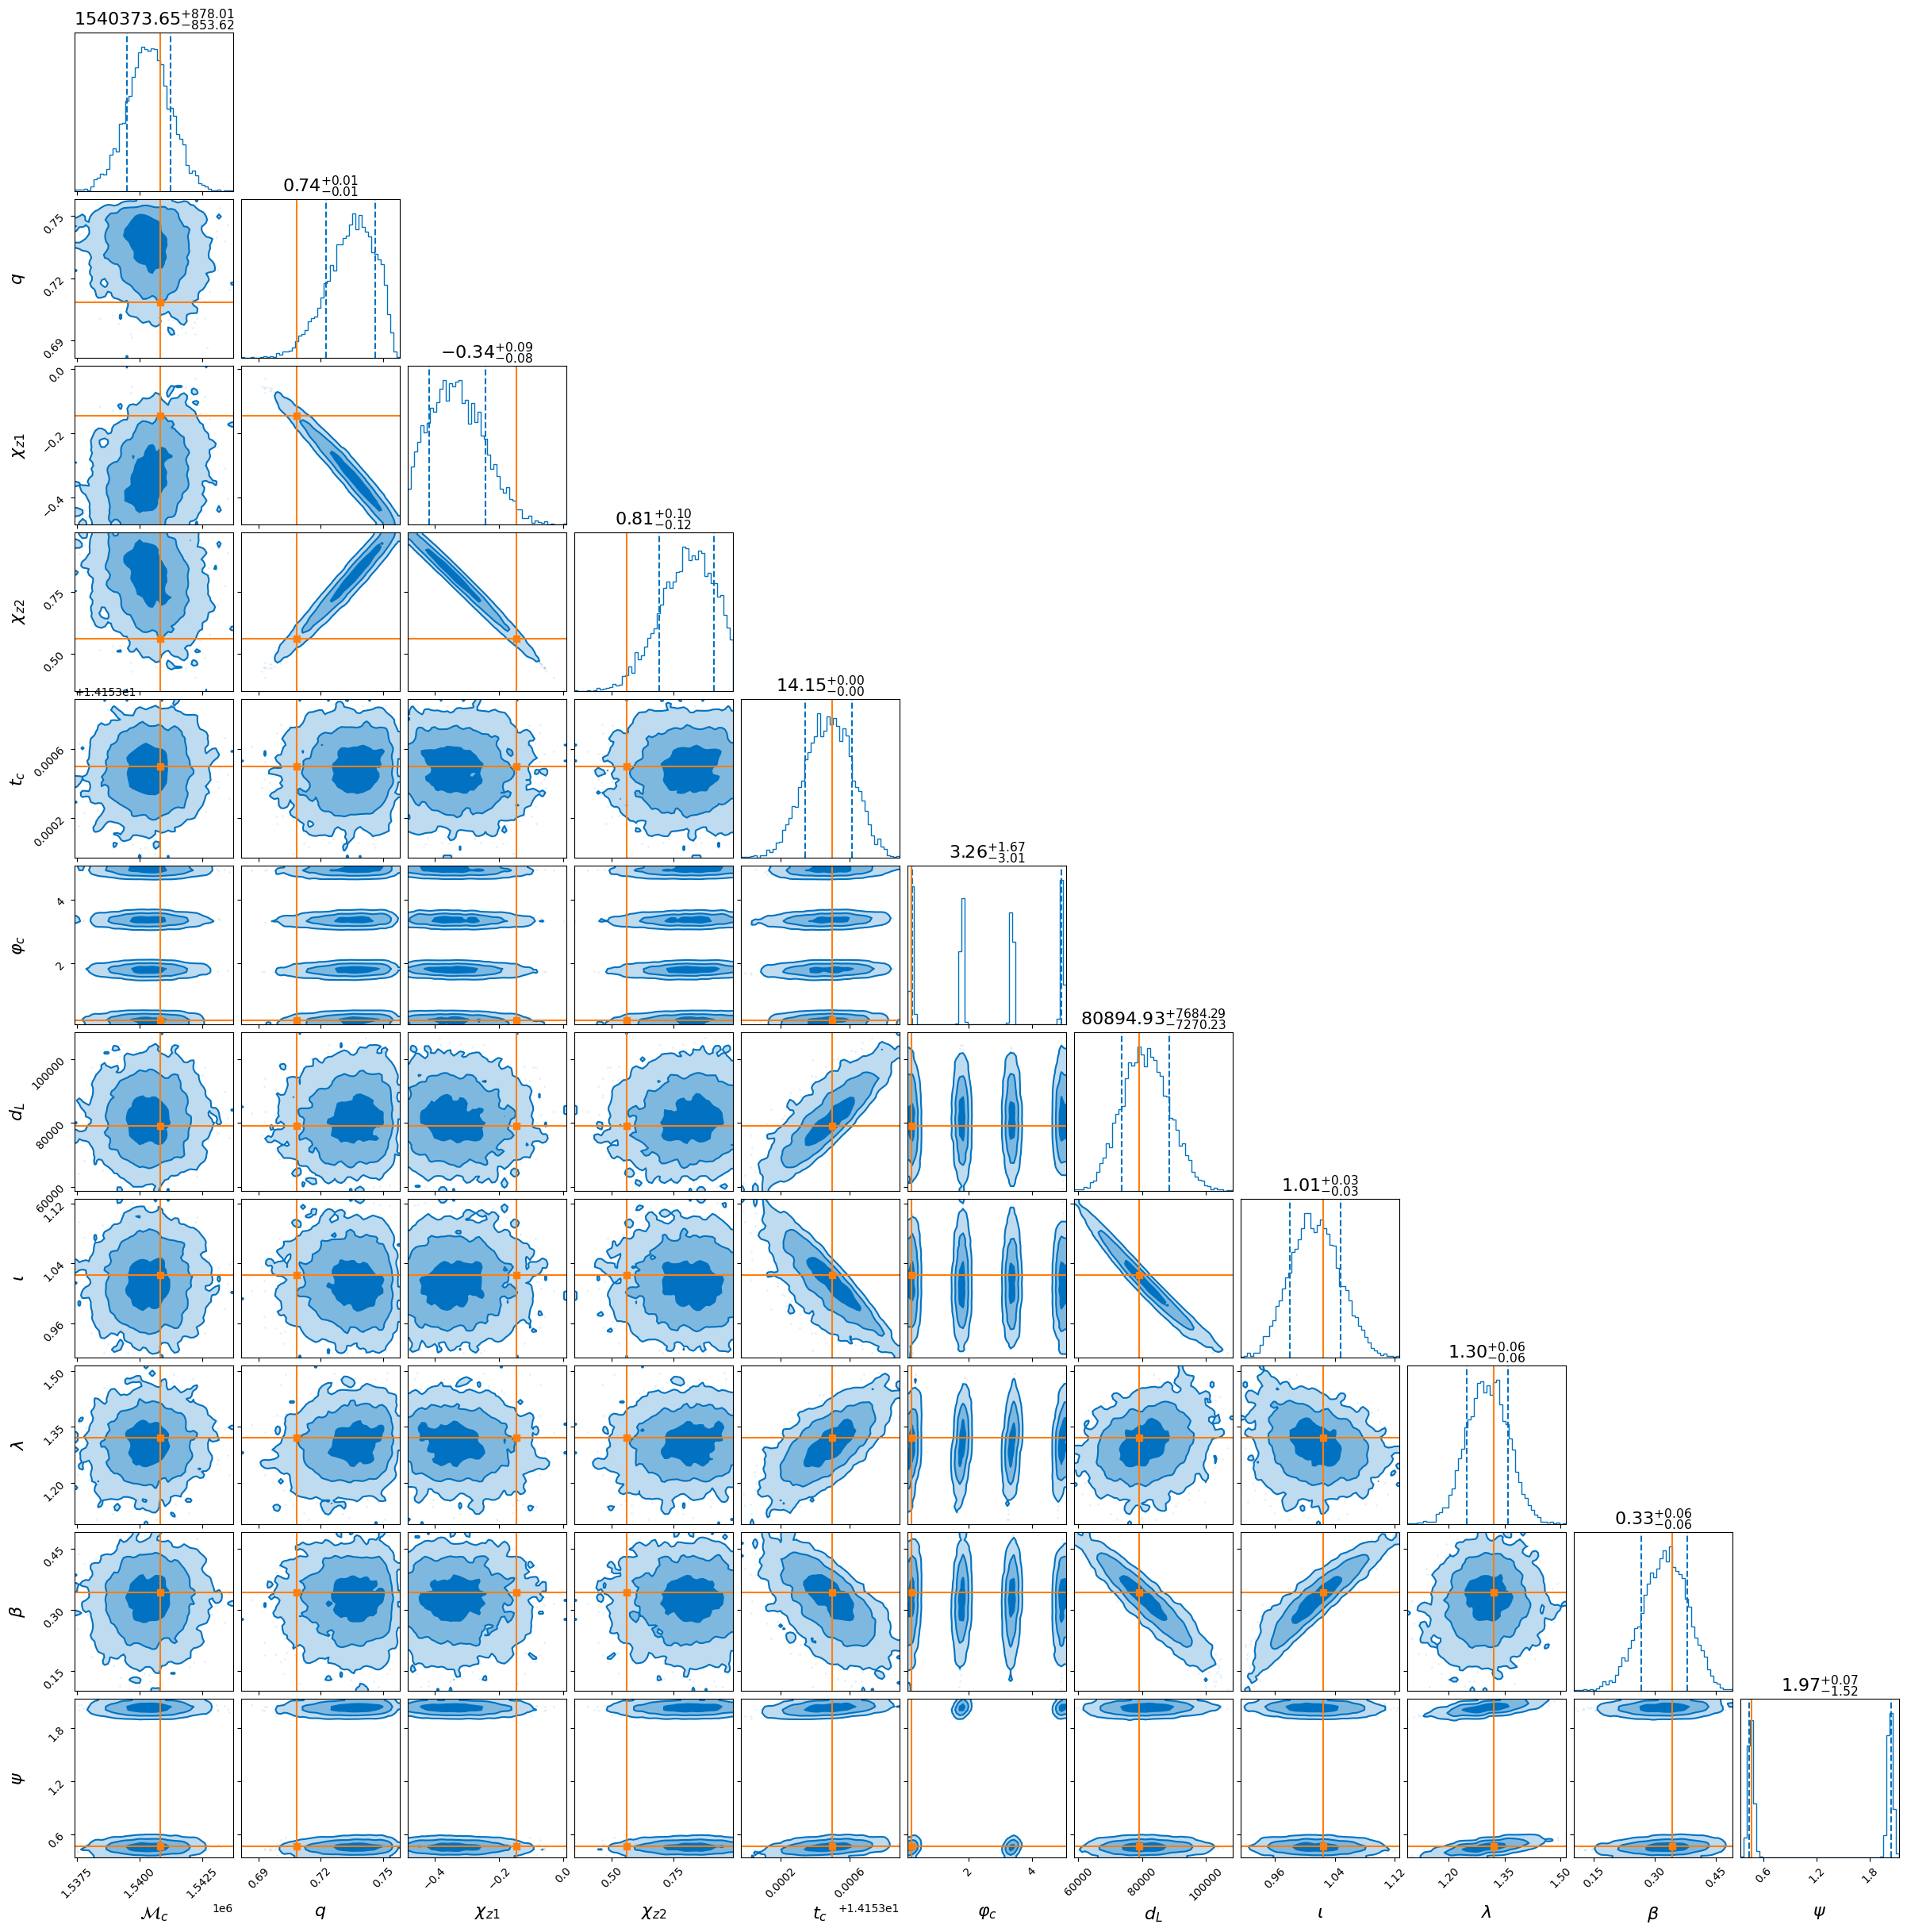

In [22]:
# Make a corner plot.
result.plot_corner(save=True)

In [23]:
priors

{'chirp_mass': Uniform(minimum=1531794.5903308636, maximum=1549873.5585351258, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5730828705896598, maximum=0.8440284230849848, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'spin_1z': Uniform(minimum=-0.99, maximum=0.7271270964950249, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None),
 'spin_2z': Uniform(minimum=-0.6244473157095929, maximum=0.99, name='spin_2z', latex_label='$\\chi_{z2}$', unit=None, boundary=None),
 'coalescence_time': Uniform(minimum=14.152558878348442, maximum=14.154440386706204, name='coalescence_time', latex_label='$t_c$', unit=None, boundary=None),
 'coalescence_phase': Uniform(minimum=0.0, maximum=6.283185307179586, name='coalescence_phase', latex_label='$\\varphi_c$', unit=None, boundary='periodic'),
 'luminosity_distance': Uniform(minimum=16868.74060253163, maximum=141047.6636953444, name='luminosity_distance', la